## Get data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

## Preprocess Data

In [ ]:
# Create function to read the lines of a document

def get_lines(filename):
  """
  Read filenames (a text filename) and return the lines of test as a list.

  Args:
    filename (str): a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename
  """

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.

  """

  input_lines = get_lines(filename) #get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  #Loop
  for line in input_lines:
    if line.startswith("###"): #check to see if the is an ID line
      abstract_id = line
      abstract_lines = ""  #reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() #split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines aree in the target abstract?  (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples listr

    else: # if the above conditions are not fulfilled, the line contains a labelled sentence
      abstract_lines += line
  return abstract_samples

In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt") #dev is an other name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135


In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

## Make numerical Labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # Sparse matrix are not compatible with tf
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1)) # We only only need top use the transform method because our one code encoder was fitted with the train data
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
#check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

#Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LAbelEncoder instances
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Tribrid embedding Model

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow.keras import layers

### Character Embedding

In [ ]:
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average chracter length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(149.3662574983337)

In [ ]:
#Fin what character length covers 95% of sequence
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKEN = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, [UNK])
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKEN,
                                           output_sequence_length=output_seq_char_len,
                                           name="char_vectorizer")

In [ ]:
# Adapt  character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Create char embedding layer
char_vocab = char_vectorizer.get_vocabulary()
char_embed = layers.Embedding(input_dim=len(char_vocab), #number of different characters
                             output_dim = 25, # this is the size of the char embedding in the paper
                              mask_zero = False,
                              name="char_embed")

### Feature extraction with pretrained embedding

In [ ]:
import keras
@keras.saving.register_keras_serializable()
class USELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)
        self.embedding_layer = hub.KerasLayer(
            "https://tfhub.dev/google/universal-sentence-encoder/4",
            dtype=tf.string,
            trainable=False
        )

    def call(self, inputs):
        return self.embedding_layer(inputs)

### Positional Embedding

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
# Check the coverage of a "total_lines"
percentile_total_lines = np.percentile(train_df["total_lines"],95)
percentile_total_lines

np.float64(18.0)

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=percentile_total_lines)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=percentile_total_lines)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=percentile_total_lines)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 18]),
 <tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]], dtype=floa

### Building a tribrid embedding model
1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs the 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype="string",name="token_inputs")
token_embeddings = USELayer()(token_inputs) # USE layer used in the model 4 for to use the pretrained model as layer
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype="string",name="char_inputs")
char_embeddings = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_embeddings)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

# 3. line_number model
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32,name="line_number_inputs") # the shape is 15 because is the shape of our encoded data
x = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,outputs=x)

# 4. Total lines model

total_lines_inputs = layers.Input(shape=(18,),dtype=tf.float32,name="total_lines_inputs")
y = layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# 5. Combine token and char embeddings into hybrid  embeddings
combine_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256,activation="relu")(combine_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine  positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="tribrid_embedding")([line_number_model.output,
                                                                   total_lines_model.output,
                                                                   z]) # we use only z because is the tensor itself, we use the output in the other because we need the output tensor of the model


# 7. Create output layer
output_layer = layers.Dense(num_classes,activation="softmax",name="output_layer")(tribrid_embeddings)

# 8. Create model with all kind of inputs
tribrid_model= tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                        outputs=output_layer,
                        name="tribrid_embedding")


In [ ]:
# Get a summary of a tribrid embedding model
tribrid_model.summary()

Model: "tribrid_embedding"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ use_layer           │ (None, 512)       │          0 │ token_inputs[0][… │
│ (USELayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ use_layer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 48)        │      9,600 │ char_embed[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_hybrid_… │ (None, 176)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_inputs  │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_inputs  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     45,312 │ char_token_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        608 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tribrid_embedding   │ (None, 320)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ tribrid_embeddin… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,001 (484.38 KB)

 Trainable params: 124,001 (484.38 KB)

 Non-trainable params: 0 (0.00 B)

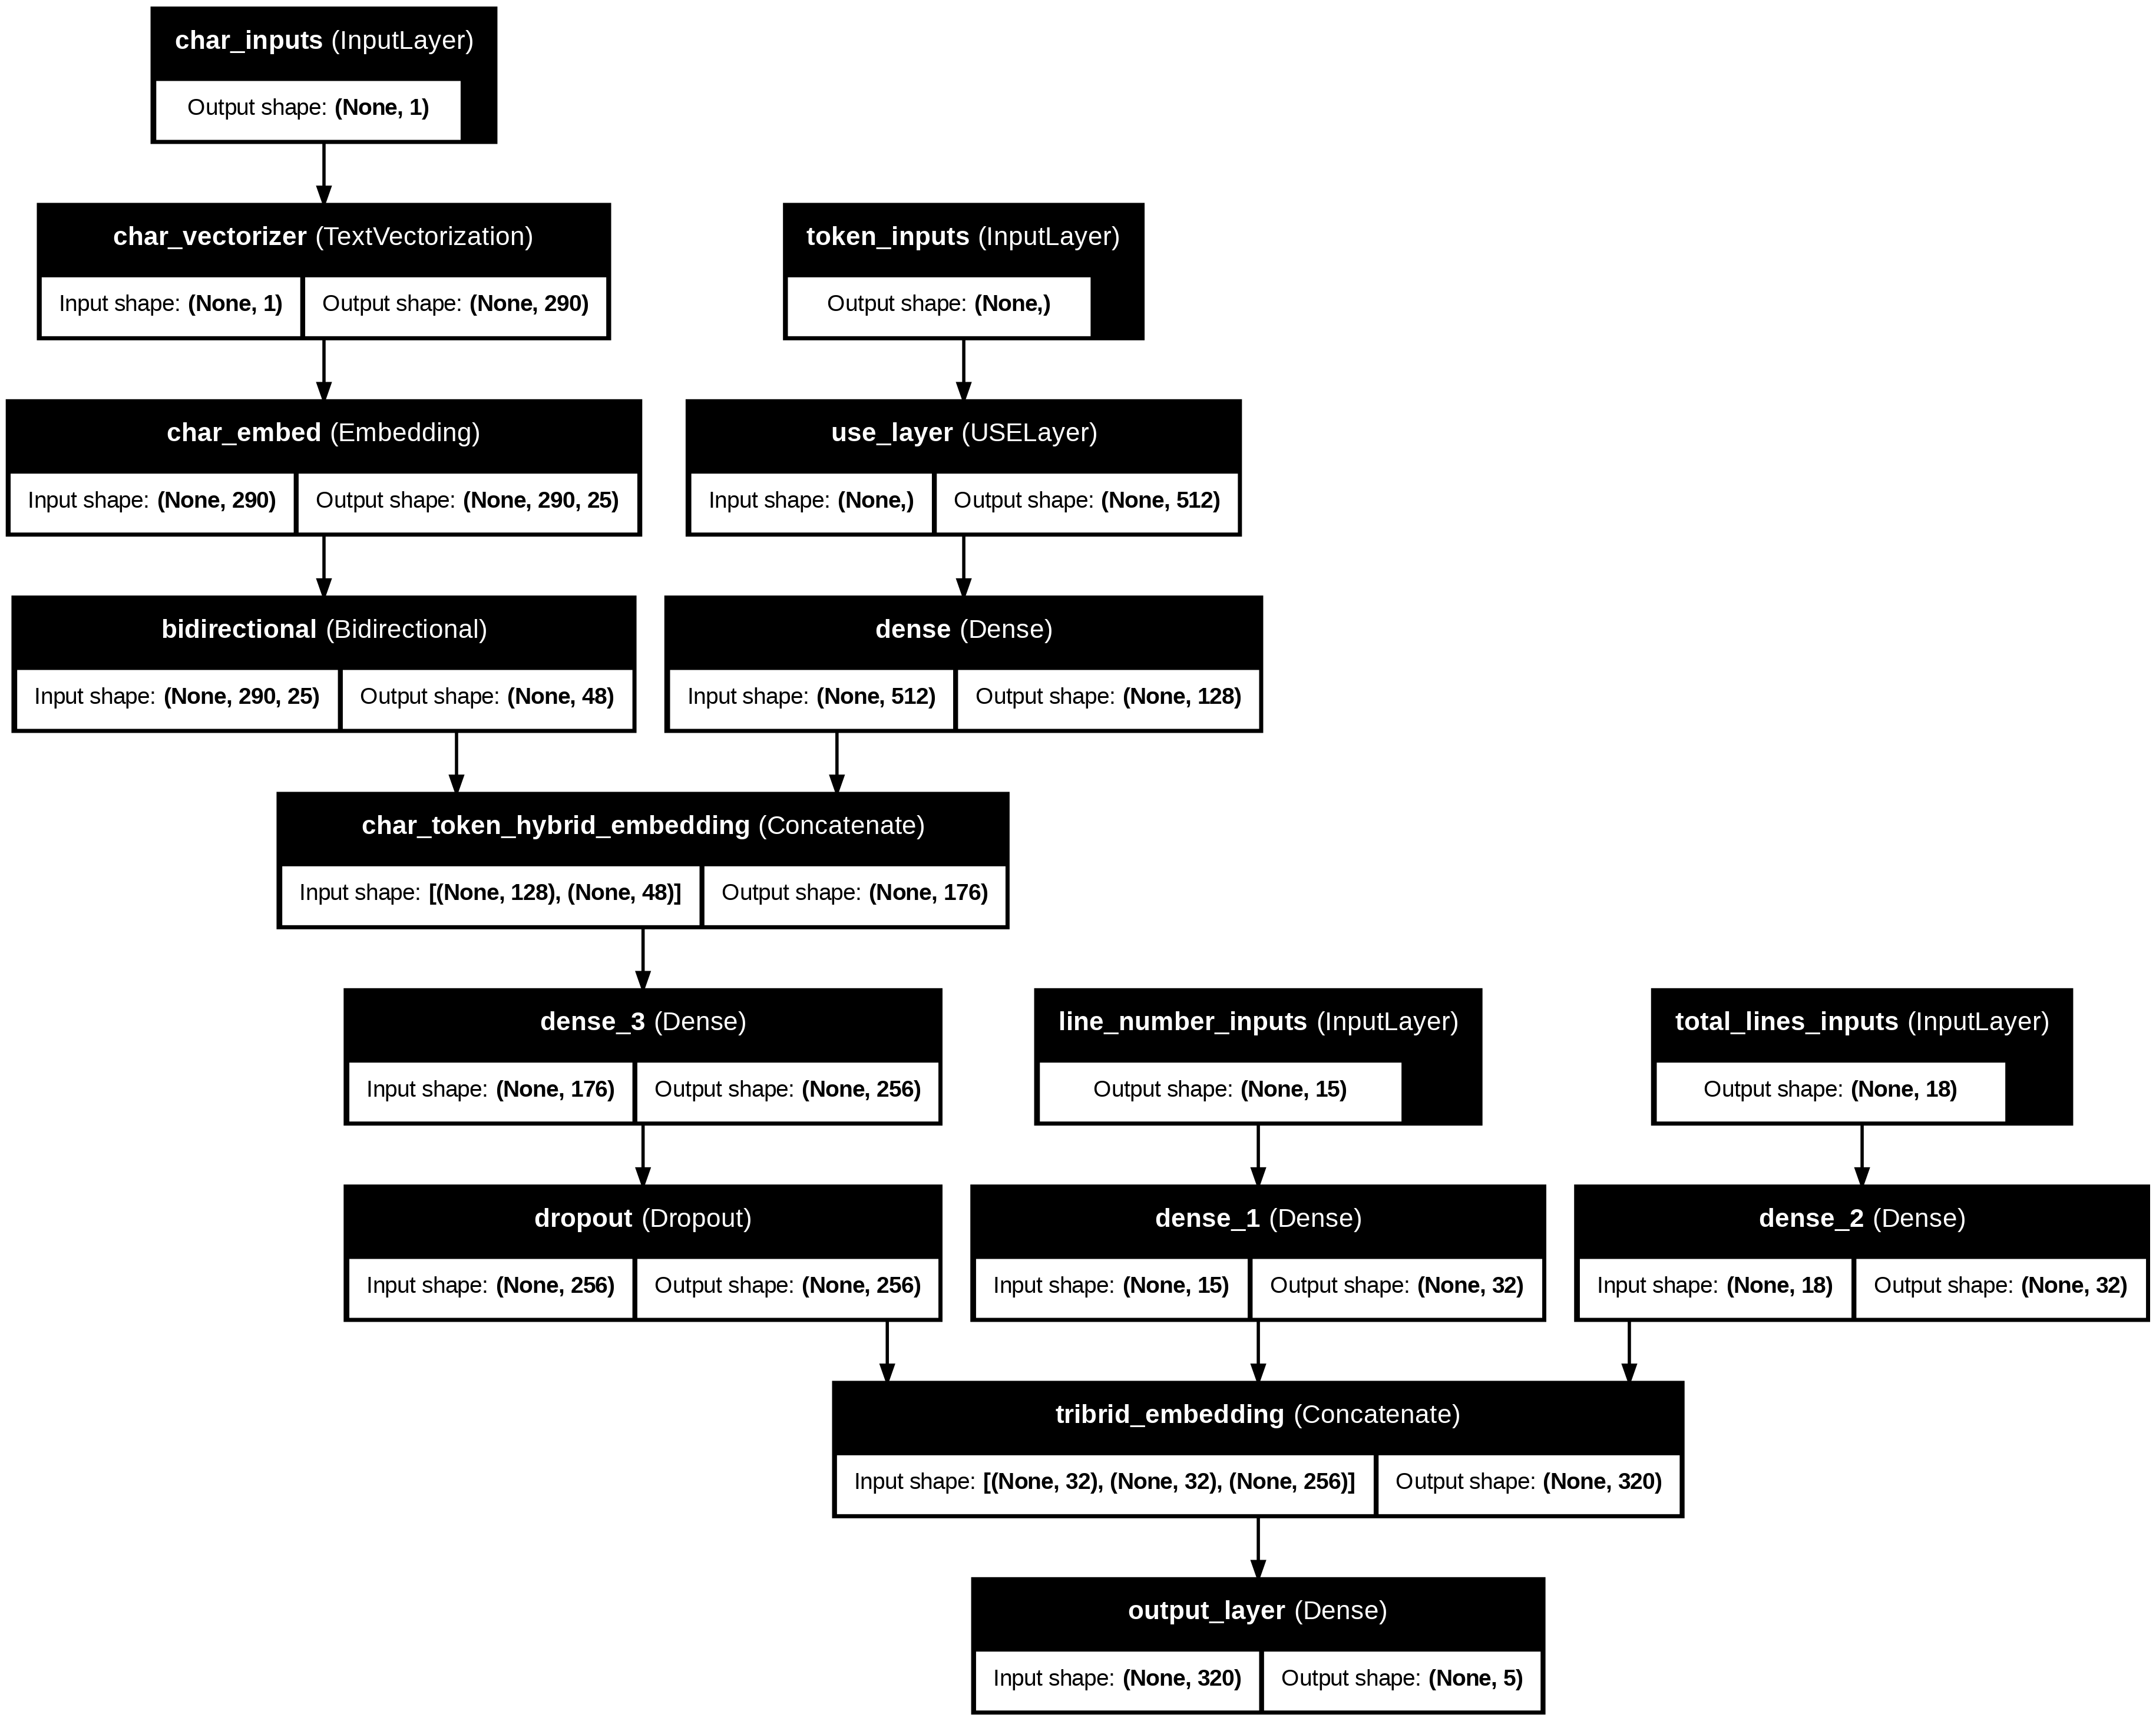

In [ ]:
# Plot model 5
tf.keras.utils.plot_model(tribrid_model,show_shapes=True,show_layer_names=True)

In [ ]:
# Compile the  tribrid embedding model
tribrid_model.compile(loss=tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Tribid embedding dataset

In [ ]:
# Create training dataset
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                        train_total_lines_one_hot,
                                                        train_sentences,train_chars))

train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data,train_tribrid_labels))

train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create validation dataset
val_tribid_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                        val_total_lines_one_hot,
                                                        val_sentences,val_chars))


val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_tribrid_dataset = tf.data.Dataset.zip((val_tribid_data,val_tribrid_labels))

val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create a test dataset
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                        test_total_lines_one_hot,
                                                        test_sentences,test_chars))

test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data,test_tribrid_labels))

test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
tribrid_model_history = tribrid_model.fit(train_tribrid_dataset,
                              steps_per_epoch = int(0.1*len(train_tribrid_dataset)),
                              epochs = 3,
                              validation_data = val_tribrid_dataset,
                              validation_steps = int(0.1*len(val_tribrid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.6495 - loss: 0.1743 - val_accuracy: 0.8082 - val_loss: 0.1361
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8121 - loss: 0.1353 - val_accuracy: 0.8271 - val_loss: 0.1311
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8180 - loss: 0.1325 - val_accuracy: 0.8268 - val_loss: 0.1302


In [ ]:
# Make predictions
tribrid_model_pred_probs = tribrid_model.predict(val_tribrid_dataset)
tribrid_model_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step


array([[0.43306997, 0.10995874, 0.02710461, 0.38698873, 0.04287792],
       [0.4651501 , 0.08541503, 0.06937116, 0.3593812 , 0.02068247],
       [0.2987109 , 0.11297907, 0.14859833, 0.35137832, 0.08833334],
       ...,
       [0.07805889, 0.14241989, 0.09067982, 0.06791697, 0.6209244 ],
       [0.05571121, 0.28418347, 0.1203719 , 0.04945556, 0.49027786],
       [0.33617553, 0.37970582, 0.12240671, 0.07448512, 0.08722689]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
tribrid_model_preds = tf.argmax(tribrid_model_pred_probs,axis=1)
tribrid_model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
tribrid_model_accuracy = tribrid_model.evaluate(val_tribrid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.8293 - loss: 0.1295


In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate model precision, recall and f1 score using "weighted average
model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(val_labels_encoded, tribrid_model_preds, average="weighted")
model_results = {"accuracy": tribrid_model_accuracy[1],
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
model_results

{'accuracy': 0.8306633234024048,
 'precision': 0.8302103147674126,
 'recall': 0.8306633125910234,
 'f1': 0.8300727844585634}